# DEMAND FORECASTING FOR SKU1

* Importing libraries

In [577]:
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox

* Data Loading

In [578]:
import pandas as pd
df = pd.read_excel("LUMAX_Data.xlsx", sheet_name='SKU1')
df = df.set_index('Date of Invoice').sort_index()

* Checking for missing dates

In [579]:
 # Create a full list of all dates from the first to the last date in your dataset, with daily frequency
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Find the dates that are in 'full_range' but NOT in your actual DataFrame index
missing_dates = full_range.difference(df.index)

# Print how many dates are missing in total
print(f"Missing Dates: {len(missing_dates)} found.")


# If there are missing dates, show the first 10 missing ones as a preview
if len(missing_dates) > 0:
    print(missing_dates[:10])
    
#  Check the difference between consecutive dates
date_diff_counts = df.index.to_series().diff().dropna().value_counts()

#  Print how often each type of date gap occurs (e.g., 1 day, 2 days, etc.)
print("\nDate Differences:")
print(date_diff_counts)

# Check if there's more than one type of date gap, or if it's not exactly 1 day
if len(date_diff_counts) > 1 or date_diff_counts.index[0] != pd.Timedelta(days=1):
    print("Data is not uniformly spaced by 1 day. Use `method='time'` for interpolation.")
else:
    print("Data is uniformly spaced by 1 day. Use `method='linear'` for interpolation.")

Missing Dates: 297 found.
DatetimeIndex(['2022-05-23', '2022-05-24', '2022-05-25', '2022-05-27',
               '2022-05-28', '2022-05-29', '2022-05-30', '2022-06-01',
               '2022-06-02', '2022-06-03'],
              dtype='datetime64[ns]', freq=None)

Date Differences:
Date of Invoice
1 days     106
2 days      32
5 days      18
3 days      18
4 days       9
6 days       5
7 days       3
8 days       3
12 days      2
10 days      2
9 days       2
11 days      1
Name: count, dtype: int64
Data is not uniformly spaced by 1 day. Use `method='time'` for interpolation.


* Check for outliers in QTY using IQR


Outliers in QTY: 18 found.
Consider using median or rolling median to smooth outlier values in QTY.


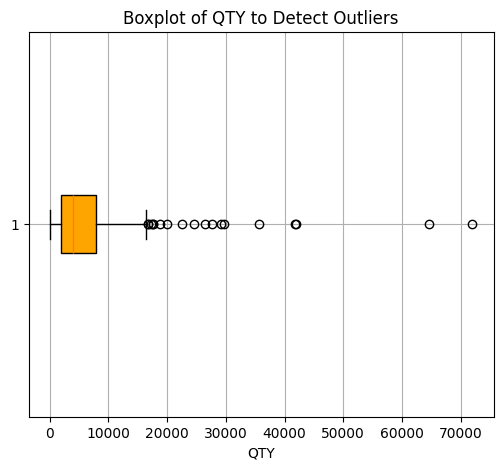

In [580]:

import matplotlib.pyplot as plt

# Your existing outlier detection
Q1 = df['QTY '].quantile(0.25)
Q3 = df['QTY '].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['QTY '] < Q1 - 1.5 * IQR) | (df['QTY '] > Q3 + 1.5 * IQR)]
 


print(f"\nOutliers in QTY: {len(outliers)} found.")
if len(outliers) > 0:
    print("Consider using median or rolling median to smooth outlier values in QTY.")
else:
    print("QTY data looks clean. You can use interpolation safely.")

# Plotting boxplot
plt.figure(figsize=(6, 5))
plt.boxplot(df['QTY '], vert=False, patch_artist=True, boxprops=dict(facecolor='orange', color='black'),)
plt.title('Boxplot of QTY to Detect Outliers')
plt.xlabel('QTY')
plt.grid(True)
plt.show()
 

 


* Reindex and show what missing rows look like

In [581]:
df_reindexed = df.reindex(full_range)
print("\nReindexed Data Preview (with NaNs):")
print(df_reindexed.head(10))


Reindexed Data Preview (with NaNs):
            Material No. Cat-III Desc      Cat-IV Desc     QTY   NET SALES
2022-05-20    61004154.0      2W BULB  2W HALOGEN BULB   7200.0  256372.70
2022-05-21    61004154.0      2W BULB  2W HALOGEN BULB   5200.0  185158.06
2022-05-22    61004154.0      2W BULB  2W HALOGEN BULB  10800.0  384559.05
2022-05-23           NaN          NaN              NaN      NaN        NaN
2022-05-24           NaN          NaN              NaN      NaN        NaN
2022-05-25           NaN          NaN              NaN      NaN        NaN
2022-05-26    61004154.0      2W BULB  2W HALOGEN BULB   6800.0  241194.91
2022-05-27           NaN          NaN              NaN      NaN        NaN
2022-05-28           NaN          NaN              NaN      NaN        NaN
2022-05-29           NaN          NaN              NaN      NaN        NaN


* Cleaning

In [582]:

# === Load the SKU1 sheet ===
df = pd.read_excel("LUMAX_Data.xlsx", sheet_name='SKU1')

# === Clean column names ===
df.columns = df.columns.str.strip()

# === Convert date column to datetime ===
df['Date of Invoice'] = pd.to_datetime(df['Date of Invoice'])

# === Set index to date ===
df.set_index('Date of Invoice', inplace=True)

# === Reindex to fill missing days ===
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_full = df.reindex(full_index)
df_full.index.name = 'Date of Invoice'


# === Apply rolling median first (smooth outliers) ===
df_full['QTY_rolled'] = df_full['QTY'].rolling(window=7, center=True, min_periods=1).median()

# === Interpolate missing values after smoothing ===
df_full['QTY_rolled'] = df_full['QTY_rolled'].interpolate(method='time').round().astype('Int64')

# === Forward-fill static info (Material No.) ===
df_full['Material No.'] = df_full['Material No.'].ffill().astype('Int64')

# === Reset index for resampling ===
df_full = df_full.reset_index()

# === Drop unneeded columns if present ===
df_cleaned = df_full.drop(columns=['Cat-III Desc', 'Cat-IV Desc', 'NET SALES'], errors='ignore')

# === Resample to weekly demand (week ending on Monday) ===
df_weekly = df_cleaned.resample('W-Mon', on='Date of Invoice').sum(numeric_only=True)['QTY_rolled'].reset_index()

# === Preview cleaned weekly data ===
print(df_weekly.head())

df['QTY'] = df['QTY'].astype(float)


  Date of Invoice  QTY_rolled
0      2022-05-23       28600
1      2022-05-30       44000
2      2022-06-06       21000
3      2022-06-13       14600
4      2022-06-20       18600


* Plotting Weekly Demand

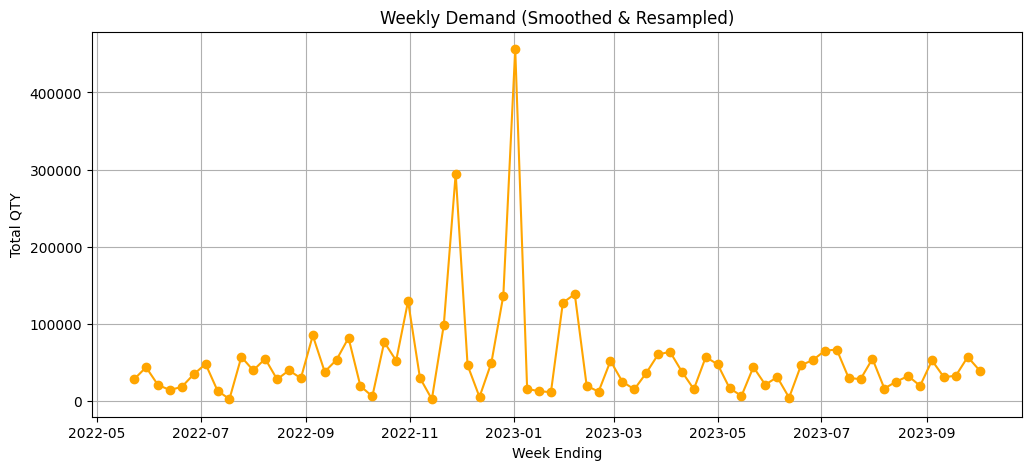

In [583]:
import pandas as pd
import matplotlib.pyplot as plt

# === Plot weekly demand ===
plt.figure(figsize=(12, 5))
plt.plot(df_weekly['Date of Invoice'], df_weekly['QTY_rolled'], marker='o',color='orange')
plt.title('Weekly Demand (Smoothed & Resampled)')
plt.xlabel('Week Ending')
plt.ylabel('Total QTY')
plt.grid(True)
plt.show()

The plot shows an increasing trend until early 2023 with large, irregular spikes and no clear seasonality. Since the fluctuations grow with the demand level, a multiplicative decomposition is appropriate because it handles changing variability better than an additive model.

* Plotting graph of BoxCox & Log Transformation

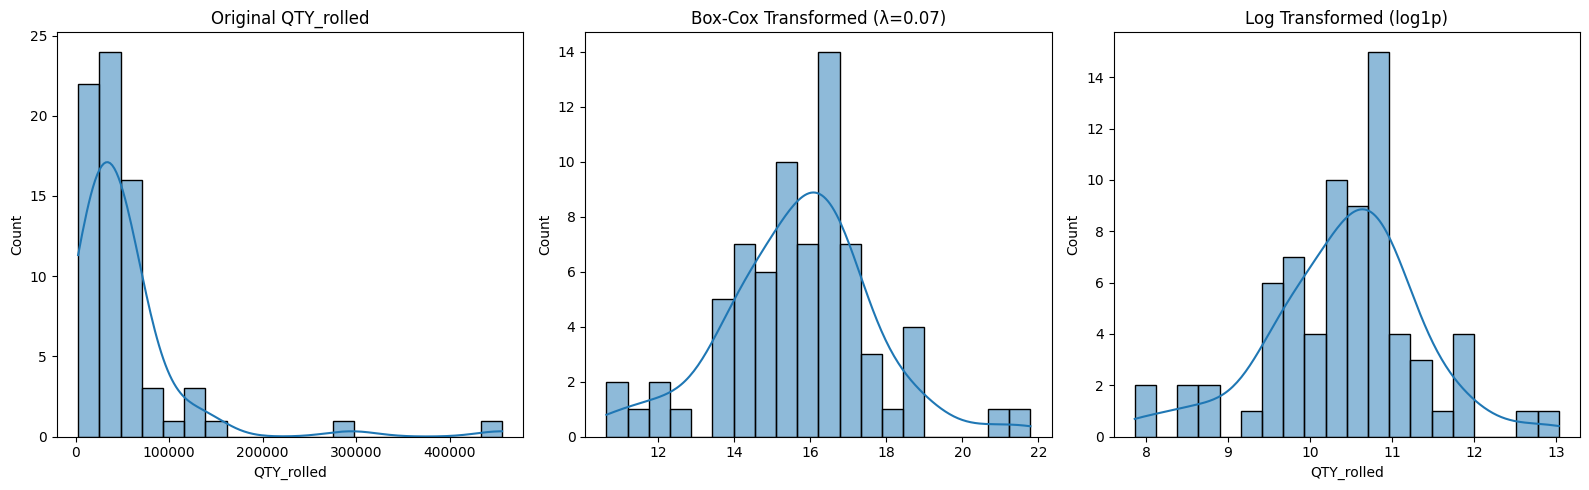

In [584]:
# Drop NaNs and non-positive values
qty = df_weekly['QTY_rolled'].dropna()
qty = qty[qty > 0]

# Box-Cox transformation
qty_boxcox, lmbda = boxcox(qty)
# Store the transformed series in your DataFrame
df_weekly['QTY_boxcox'] = qty_boxcox

# Log transformation 
qty_log = np.log1p(qty)  # log1p handles zero values safely
df_weekly['QTY_log'] = qty_log

# Plotting
plt.figure(figsize=(16, 5))

# Original
plt.subplot(1, 3, 1)
sns.histplot(qty, kde=True, bins=20)
plt.title("Original QTY_rolled")

# Box-Cox
plt.subplot(1, 3, 2)
sns.histplot(qty_boxcox, kde=True, bins=20)
plt.title(f"Box-Cox Transformed (λ={lmbda:.2f})")

# Log Transformed
plt.subplot(1, 3, 3)
sns.histplot(qty_log, kde=True, bins=20)
plt.title("Log Transformed (log1p)")

plt.tight_layout()
plt.show()

* Seasonal Decomposition

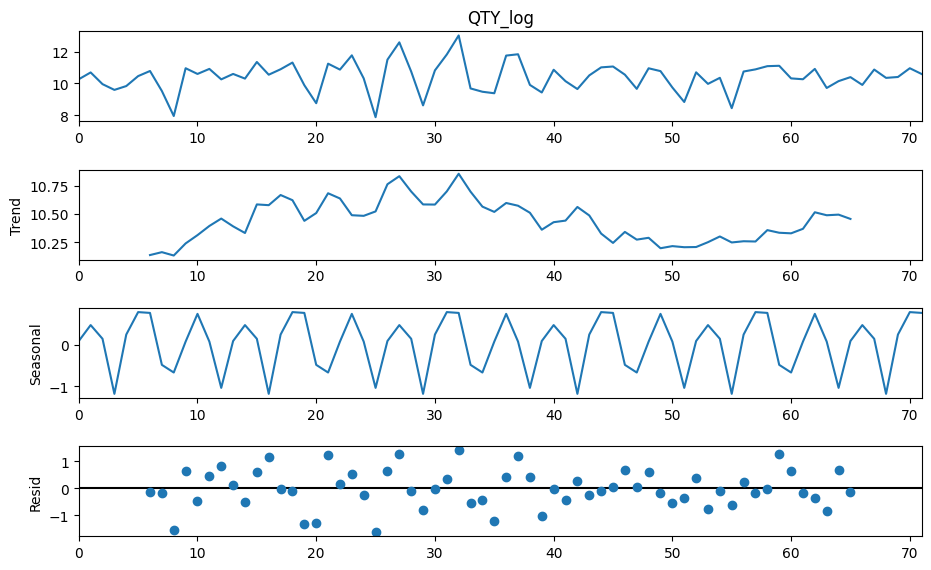

In [585]:
result = seasonal_decompose(df_weekly['QTY_log'], model='additive', period=13)  
fig = result.plot()
fig.set_size_inches(10, 6)
plt.show()

* STL Decomposition

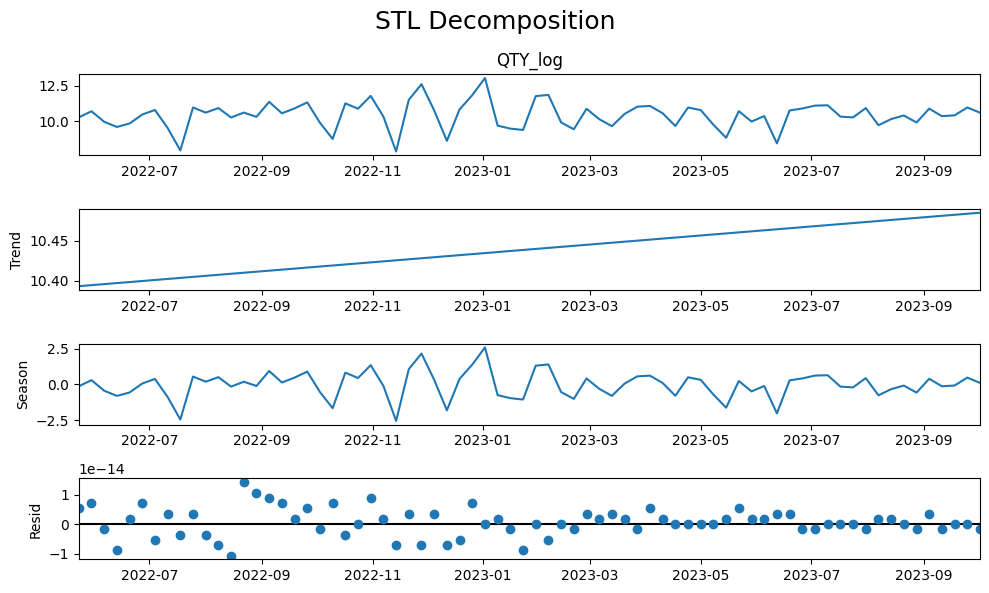

In [586]:
#STL Decomposition
from statsmodels.tsa.seasonal import STL
df_weekly.set_index('Date of Invoice', inplace=True)

# STL expects a datetime index with frequency
df_weekly.index = pd.to_datetime(df_weekly.index)
df_weekly = df_weekly.asfreq('W-MON')

# STL Decomposition (seasonal_period=53 closer to 52 for weekly data)
stl = STL(df_weekly['QTY_log'], seasonal=53)
result = stl.fit()

# Plot the components
fig = result.plot()
fig.set_size_inches(10, 6)
plt.suptitle("STL Decomposition", fontsize=18)
plt.tight_layout()
plt.show()

Data is very noisy and seasonality is not stable (sometimes strong, sometimes weak).

So, STL is much better at handling irregular seasonality and outliers compared to seasonal_decompose.

* ADF Test For Checking Stationarity


ADF Test for Differencing Level: 0
ADF Statistic: -3.199417904239458
p-value: 0.02001839794084341
Critical Value (1%): -3.5352168748293127
Critical Value (5%): -2.9071540828402367
Critical Value (10%): -2.5911025443786984

The series is stationary (reject null hypothesis)

Total differencing applied: 0


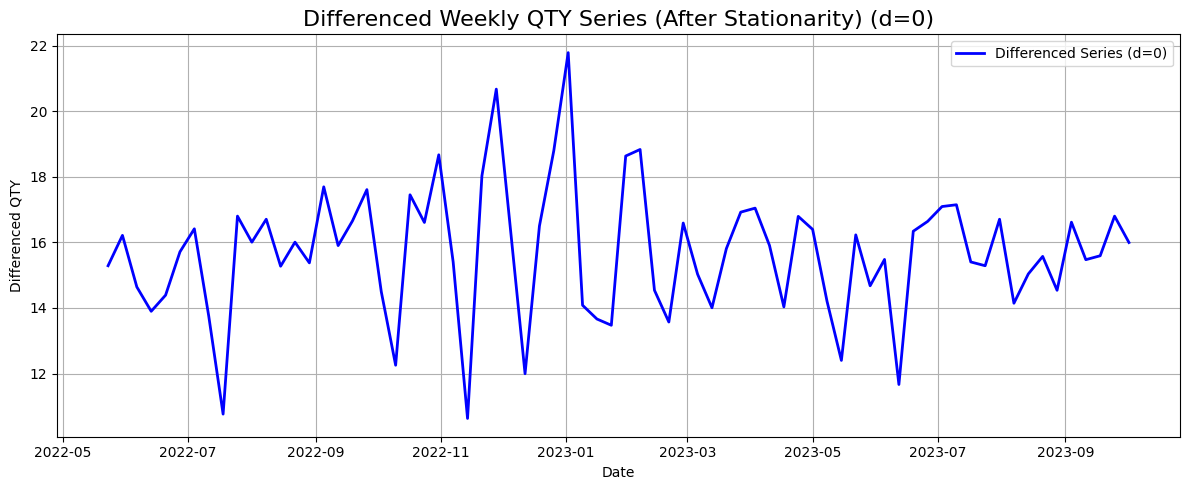

In [587]:
 
diff_series = df_weekly['QTY_boxcox'].copy()
d = 0  # Differencing counter

while True:
    print(f"\nADF Test for Differencing Level: {d}")
    result = adfuller(diff_series.dropna())

    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")

    if result[1] < 0.05:
        print("\nThe series is stationary (reject null hypothesis)")
        break
    else:
        print("The series is non-stationary, applying differencing...")
        diff_series = diff_series.diff().dropna()
        d += 1

print(f"\nTotal differencing applied: {d}")

# Plotting the differenced series
plt.figure(figsize=(12, 5))
plt.plot(diff_series, color='blue', linewidth=2, label=f'Differenced Series (d={d})')
plt.title(f'Differenced Weekly QTY Series (After Stationarity) (d={d})', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Differenced QTY')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* ACF & PACF Plots

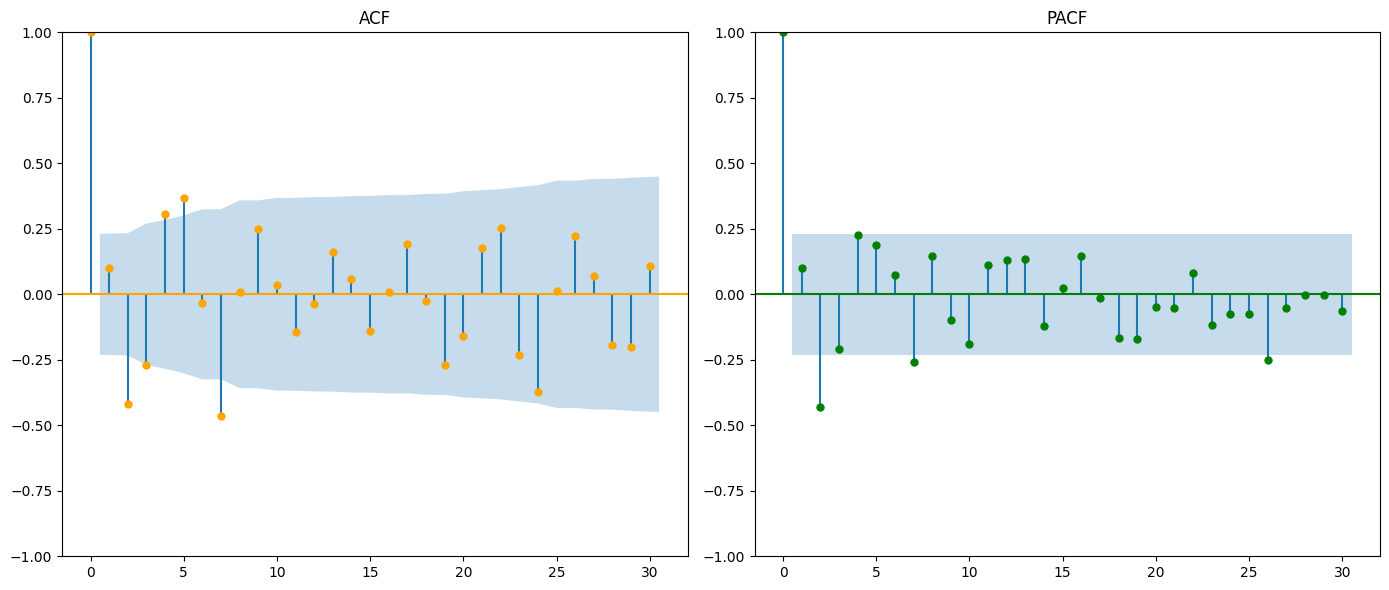

In [588]:
 # Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(diff_series, lags=30, ax=plt.gca(),color='orange')
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(diff_series, lags=30, ax=plt.gca(), method='ywm',color='green')
plt.title('PACF')

plt.tight_layout()
plt.show()

🔵 ACF (Left plot)
Big spike at lag 1 (very strong autocorrelation).

After lag 1, autocorrelations quickly drop and stay inside the blue confidence bands (small, random noise).

No slow decay — it drops immediately.

Interpretation:
➡️ Suggests that an MA(1) model might be appropriate (Moving Average order 1).
➡️ MA models are suggested when ACF cuts off sharply after a few lags.


🟠 PACF (Right plot)
Big spike at lag 1 too.

Then small and random spikes for other lags (inside the blue area).

No significant pattern beyond lag 1.

Interpretation:
➡️ Suggests an AR(1) model might also fit (AutoRegressive order 1).
➡️ AR models are suggested when PACF cuts off sharply.

✨ Final takeaway for the model:
Both ACF and PACF have strong spikes only at lag 1.

So ARIMA(1, d, 1) could be a good starting point, where:

1 for AR (p=1 from PACF),

d is how many times differenced (check ADF test),

1 for MA (q=1 from ACF).

* Ljung-Box Test (Statistical Test for White Noise)

In [589]:
# Apply Ljung-Box test on the differenced series
ljung_box_result = acorr_ljungbox(diff_series.dropna(), lags=[10], return_df=True)

print("Ljung-Box Test Result:")
print(ljung_box_result)

# Interpretation
p_value = ljung_box_result['lb_pvalue'].values[0]

if p_value > 0.05:
    print("\nThe series appears to be white noise (p-value > 0.05).")
    print("→ It has no predictable structure. Forecasting may not be meaningful.")
else:
    print("\nThe series is NOT white noise (p-value <= 0.05).")
    print("→ It has autocorrelation and structure that can be modeled.")

Ljung-Box Test Result:
      lb_stat     lb_pvalue
10  61.096191  2.246654e-09

The series is NOT white noise (p-value <= 0.05).
→ It has autocorrelation and structure that can be modeled.


* Train-Test Split, Log Transformation, and Model Evaluation Setup

In [590]:
from statsmodels.tsa.seasonal import STL
warnings.filterwarnings("ignore")

train = df_weekly[:-3]
test = df_weekly[-3:]
y_train = train['QTY_rolled'].astype(float)
y_test = test['QTY_rolled'].astype(float)

# Handle zero or negative values in the data before log transformation
y_train_clean = y_train.copy()
y_test_clean = y_test.copy()

# Replace zero or negative values with small positive values
y_train_clean[y_train_clean <= 0] = 1e-6
y_test_clean[y_test_clean <= 0] = 1e-6

# Log-transform train and test series
y_train_log = np.log1p(y_train_clean)
y_test_log = np.log1p(y_test_clean)

#  ADD STL DECOMPOSITION
stl = STL(y_train_log, period=52, robust=True)   # 52 weeks = annual seasonality
res = stl.fit()

best_method = None
best_mape = float('inf')
results = {}
forecast_4weeks = {}
test_forecasts = {}


Evaluating different time series forecasting models using log-transformed training data and then checking how good the models are using the MAPE metric

Naive - MAPE: 24.23%
Moving Average - MAPE: 22.16%
SES - MAPE: 19.86%
Holt Linear - MAPE: 19.62%
Holt-Winters - MAPE: 36.85%
ARIMA - MAPE: 20.01%
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=521.612, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=444.801, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=380.423, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=353.925, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=200.289, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=197.743, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=321.158, Time=0.23 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=197.039, 

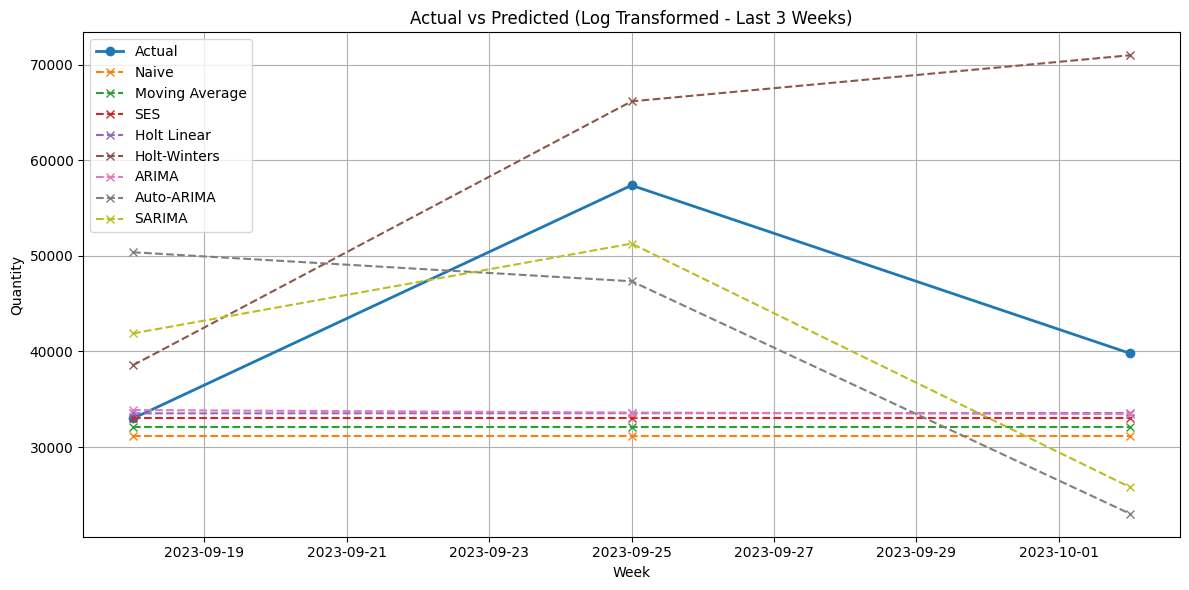

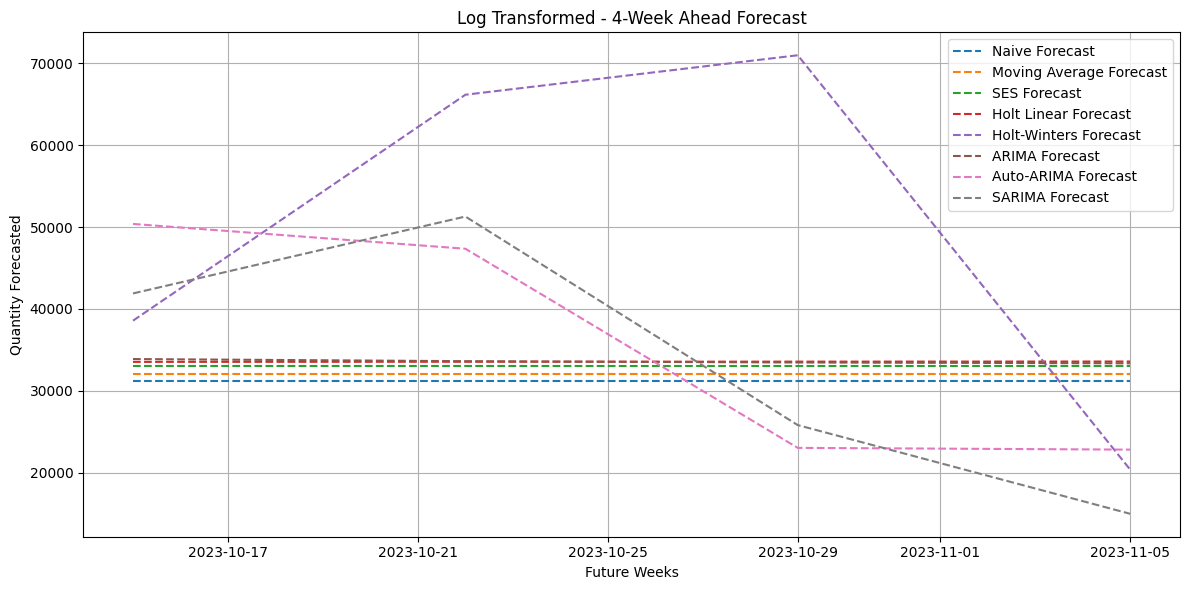


4-Week Forecast by Best Model (Holt Linear):
2023-09-18    33526
2023-09-25    33541
2023-10-02    33556
2023-10-09    33570
Freq: W-MON, dtype: int32


In [591]:
def evaluate_model(name, forecast_test_log, forecast_future_log):
    global best_method, best_mape
    try:
        # Inverse transformation
        forecast_test = np.round(np.expm1(forecast_test_log)).astype(int)
        forecast_future = np.round(np.expm1(forecast_future_log)).astype(int)

        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_test, forecast_test)
        results[name] = mape
        test_forecasts[name] = forecast_test
        forecast_4weeks[name] = forecast_future

        if mape < best_mape:
            best_mape = mape
            best_method = name
        print(f"{name} - MAPE: {mape * 100:.2f}%")
    except Exception as e:
        print(f"{name} - Error: {e}")

# Models

# Naive model
try:
    naive_test = [y_train_log.iloc[-1]] * 3
    naive_future = [y_train_log.iloc[-1]] * 4
    evaluate_model("Naive", naive_test, naive_future)
except Exception as e:
    print("Naive - Error:", e)

# Moving Average model
try:
    ma_test = [y_train_log[-3:].mean()] * 3
    ma_future = [y_train_log[-3:].mean()] * 4
    evaluate_model("Moving Average", ma_test, ma_future)
except Exception as e:
    print("Moving Average - Error:", e)

# Simple Exponential Smoothing (SES)
try:
    ses_model = SimpleExpSmoothing(y_train_log).fit()
    ses_test = ses_model.forecast(3)
    ses_future = ses_model.forecast(4)
    evaluate_model("SES", ses_test, ses_future)
except Exception as e:
    print("SES - Error:", e)

# Holt Linear
try:
    holt_model = Holt(y_train_log).fit()
    holt_test = holt_model.forecast(3)
    holt_future = holt_model.forecast(4)
    evaluate_model("Holt Linear", holt_test, holt_future)
except Exception as e:
    print("Holt Linear - Error:", e)

# Holt-Winters
try:
    hw_model = ExponentialSmoothing(y_train_log, seasonal='mul', seasonal_periods=13).fit()
    hw_test = hw_model.forecast(3)
    hw_future = hw_model.forecast(4)
    evaluate_model("Holt-Winters", hw_test, hw_future)
except Exception as e:
    print("Holt-Winters - Error:", e)

# ARIMA
try:
    arima_model = ARIMA(y_train_log, order=(1,0,1)).fit()
    arima_test = arima_model.forecast(3)
    arima_future = arima_model.forecast(4)
    evaluate_model("ARIMA", arima_test, arima_future)
except Exception as e:
    print("ARIMA - Error:", e)

# Auto-ARIMA
try:
    auto_model = auto_arima(y_train_log, seasonal=False, stepwise=True, trace=True)
    auto_test = auto_model.predict(n_periods=3)
    auto_future = auto_model.predict(n_periods=4)
    evaluate_model("Auto-ARIMA", auto_test, auto_future)
except Exception as e:
    print("Auto-ARIMA - Error:", e)

# SARIMA
try:
    sarima_model = SARIMAX(y_train_log, order=(1, 0, 1), seasonal_order=(1, 0, 1, 52)).fit()
    sarima_test = sarima_model.forecast(3)
    sarima_future = sarima_model.forecast(4)
    evaluate_model("SARIMA", sarima_test, sarima_future)
except Exception as e:
    print("SARIMA - Error:", e)

# Output best method
if best_mape < 0.10:
    print(f"\n Best method: {best_method} with MAPE: {best_mape * 100:.2f}%")
else:
    print("\n No method achieved MAPE < 10%")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual", marker='o', linewidth=2)
for name, forecast in test_forecasts.items():
    plt.plot(y_test.index, forecast, label=f"{name}", linestyle='--', marker='x')
plt.title("Actual vs Predicted (Log Transformed - Last 3 Weeks)")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot next 4-week forecasts
plt.figure(figsize=(12, 6))
future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
for name, forecast in forecast_4weeks.items():
    plt.plot(future_index, forecast, label=f"{name} Forecast", linestyle='--')
plt.title("Log Transformed - 4-Week Ahead Forecast")
plt.xlabel("Future Weeks")
plt.ylabel("Quantity Forecasted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the best 4-week forecast
if best_method and best_method in forecast_4weeks:
    print(f"\n4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\nNo valid forecast available from models with MAPE < 10%")


* Model Training, Evaluation (MAPE Based), and Future Forecasting with Inverse Box-Cox Transformation

Naive - MAPE: 24.23%
Moving Average - MAPE: 22.16%
SES - MAPE: 19.86%
Holt Linear - MAPE: 19.62%
Holt-Winters - MAPE: 36.85%
ARIMA - MAPE: 20.01%
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=521.612, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=444.801, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=380.423, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=353.925, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=200.289, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=197.743, Time=0.19 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=321.158, Time=0.27 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=197.039, 

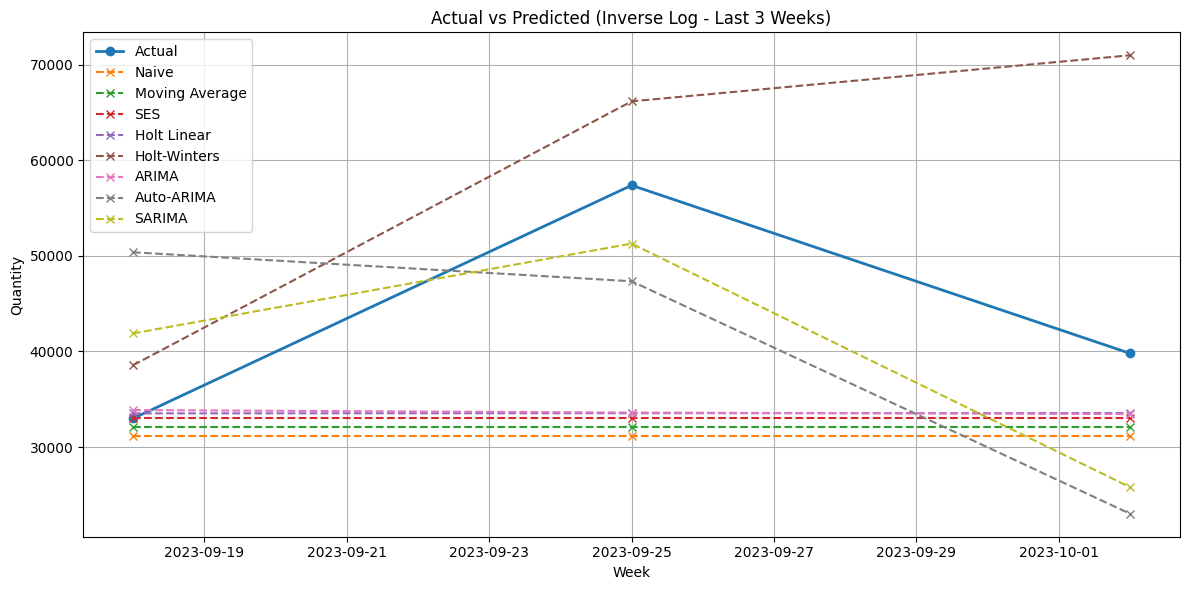

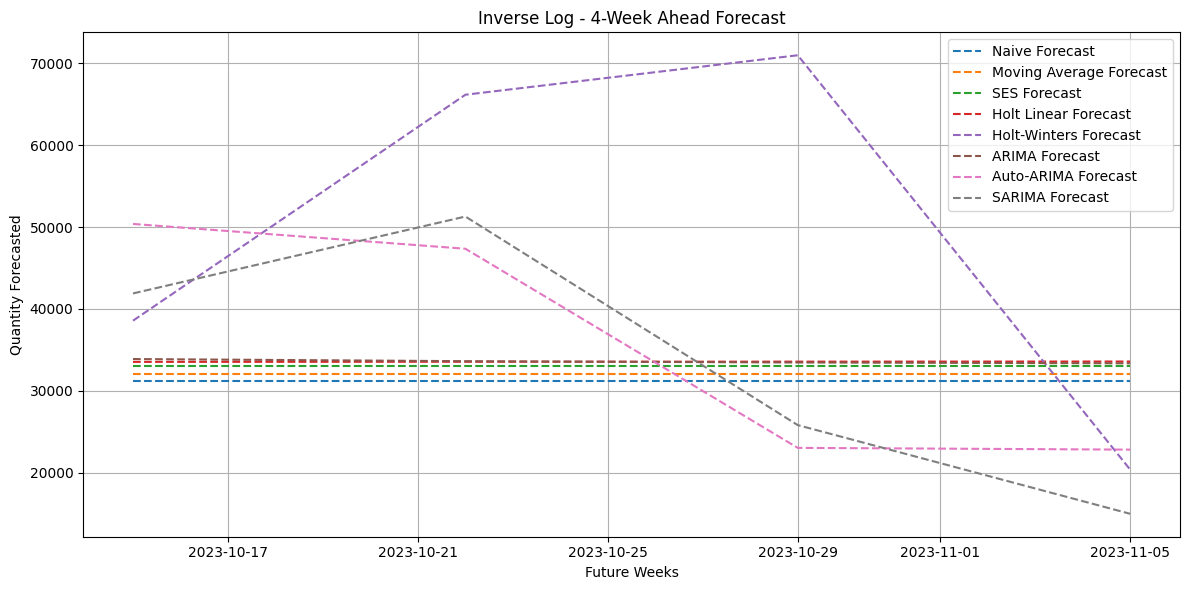


4-Week Forecast by Best Model (Holt Linear):
2023-09-18    33526
2023-09-25    33541
2023-10-02    33556
2023-10-09    33570
Freq: W-MON, dtype: int32


In [592]:
# train = df_weekly[:-3]
# test = df_weekly[-3:]
# y_train = train['QTY_boxcox']
# y_test = test['QTY_boxcox']
# best_method = None
# best_mape = float('inf')

# test_forecasts = {}
# forecast_4weeks = {}

# # Store fitted lambda used for boxcox
# fitted_lambda = lmbda 

# # def evaluate_model(name, forecast_test, forecast_future):
# #     global best_method, best_mape
# #     try:
# #         mape = mean_absolute_percentage_error(y_test, forecast_test)
# #         results[name] = mape
# #         test_forecasts[name] = forecast_test
# #         forecast_4weeks[name] = forecast_future
# #         if mape < best_mape:
# #             best_mape = mape
# #             best_method = name
# #         print(f"{name} - MAPE: {mape * 100:.2f}%")
# #     except Exception as e:
# #         print(f"{name} - Error: {e}")

# from sklearn.metrics import mean_absolute_percentage_error
# import numpy as np

# # Split the data
# train = df_weekly[:-3].astype(float)  # Ensure all data is float for calculations
# test = df_weekly[-3:].astype(float)
# y_train = train['QTY_log'].astype(float) # <-- Use log-transformed quantity
# y_test = test['QTY_log'].astype(float)

# best_method = None
# best_mape = float('inf')

# test_forecasts = {}
# forecast_4weeks = {}
# results = {}

# # # Safe inverse of log
# # def safe_exp(series):
# #     series = np.where(np.isfinite(series), series, np.nan)
# #     return np.round(np.exp(series)).astype(int)
# # def safe_exp(series):
# #     # Convert to numpy array to ensure compatibility
# #     series = np.array(series)

# #     # Replace non-finite values with 0 before exponentiation
# #     series = np.where(np.isfinite(series), series, 0)

# #     # Take exp and round, then clip to avoid overflow when casting to int
# #     exp_values = np.exp(series)
# #     exp_values = np.round(exp_values)

# #     # Replace inf or NaN with 0 after exp just in case
# #     exp_values = np.where(np.isfinite(exp_values), exp_values, 0)

# #     return exp_values.astype(int)

# def safe_exp(series):
#     series = np.array(series, dtype=np.float64)  # Ensure it's float64
#     series = np.where(np.isfinite(series), series, 0)  # Replace NaN/inf with 0
#     exp_values = np.exp(series)
#     exp_values = np.where(np.isfinite(exp_values), exp_values, 0)
#     return np.round(exp_values).astype(int)


# def evaluate_model(name, forecast_test, forecast_future):
#     global best_method, best_mape

#     try:
#         forecast_test_inv = np.exp(forecast_test)
#         y_test_inv = np.exp(y_test)

#         mape = mean_absolute_percentage_error(y_test_inv, forecast_test_inv)
#         results[name] = mape

#         test_forecasts[name] = safe_exp(forecast_test)
#         forecast_4weeks[name] = safe_exp(forecast_future)

#         if mape < best_mape:
#             best_mape = mape
#             best_method = name

#         print(f"{name} - MAPE: {mape * 100:.2f}%")
#         print(f"Predicted: {safe_exp(forecast_test)}")

#     except Exception as e:
#         print(f"{name} - Error: {e}")



from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Prepare data
train = df_weekly[:-3]
test = df_weekly[-3:]
y_train = train['QTY_rolled']
y_test = test['QTY_rolled']

# Replace zero or negative values before log transformation
y_train[y_train <= 0] = 1e-6
y_test[y_test <= 0] = 1e-6

# Log transformation
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# STL decomposition
stl = STL(y_train_log, period=52, robust=True)
res = stl.fit()

# Initialize
best_method = None
best_mape = float('inf')
results = {}
forecast_4weeks = {}
test_forecasts = {}

# Evaluation function with inverse-log transformation
def evaluate_model(name, forecast_test_log, forecast_future_log):
    global best_method, best_mape
    try:
        forecast_test = np.round(np.expm1(forecast_test_log)).astype(int)
        forecast_future = np.round(np.expm1(forecast_future_log)).astype(int)
        actual_test = np.round(np.expm1(y_test_log)).astype(int)

        mape = mean_absolute_percentage_error(actual_test, forecast_test)
        results[name] = mape
        test_forecasts[name] = forecast_test
        forecast_4weeks[name] = forecast_future

        if mape < best_mape:
            best_mape = mape
            best_method = name
        print(f"{name} - MAPE: {mape * 100:.2f}%")
    except Exception as e:
        print(f"{name} - Error: {e}")

# Naive
try:
    naive_test = [y_train_log.iloc[-1]] * 3
    naive_future = [y_train_log.iloc[-1]] * 4
    evaluate_model("Naive", naive_test, naive_future)
except Exception as e:
    print("Naive - Error:", e)

# Moving Average
try:
    ma_test = [y_train_log[-3:].mean()] * 3
    ma_future = [y_train_log[-3:].mean()] * 4
    evaluate_model("Moving Average", ma_test, ma_future)
except Exception as e:
    print("Moving Average - Error:", e)

# SES
try:
    ses_model = SimpleExpSmoothing(y_train_log).fit()
    evaluate_model("SES", ses_model.forecast(3), ses_model.forecast(4))
except Exception as e:
    print("SES - Error:", e)

# Holt Linear
try:
    holt_model = Holt(y_train_log).fit()
    evaluate_model("Holt Linear", holt_model.forecast(3), holt_model.forecast(4))
except Exception as e:
    print("Holt Linear - Error:", e)

# Holt-Winters
try:
    hw_model = ExponentialSmoothing(y_train_log, seasonal='mul', seasonal_periods=13).fit()
    evaluate_model("Holt-Winters", hw_model.forecast(3), hw_model.forecast(4))
except Exception as e:
    print("Holt-Winters - Error:", e)

# ARIMA
try:
    arima_model = ARIMA(y_train_log, order=(1,0,1)).fit()
    evaluate_model("ARIMA", arima_model.forecast(3), arima_model.forecast(4))
except Exception as e:
    print("ARIMA - Error:", e)

# Auto ARIMA
try:
    auto_model = auto_arima(y_train_log, seasonal=False, stepwise=True, trace=True)
    evaluate_model("Auto-ARIMA", auto_model.predict(n_periods=3), auto_model.predict(n_periods=4))
except Exception as e:
    print("Auto-ARIMA - Error:", e)

# SARIMA
try:
    sarima_model = SARIMAX(y_train_log, order=(1, 0, 1), seasonal_order=(1, 0, 1, 52)).fit()
    evaluate_model("SARIMA", sarima_model.forecast(3), sarima_model.forecast(4))
except Exception as e:
    print("SARIMA - Error:", e)

# Print Best Method
if best_mape < 0.10:
    print(f"\n Best method: {best_method} with MAPE: {best_mape * 100:.2f}%")
else:
    print("\n No method achieved MAPE < 10%")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, np.expm1(y_test_log), label="Actual", marker='o', linewidth=2)
for name, forecast in test_forecasts.items():
    plt.plot(y_test.index, forecast, label=f"{name}", linestyle='--', marker='x')
plt.title("Actual vs Predicted (Inverse Log - Last 3 Weeks)")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot future forecast
plt.figure(figsize=(12, 6))
future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
for name, forecast in forecast_4weeks.items():
    plt.plot(future_index, forecast, label=f"{name} Forecast", linestyle='--')
plt.title("Inverse Log - 4-Week Ahead Forecast")
plt.xlabel("Future Weeks")
plt.ylabel("Quantity Forecasted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show best model's 4-week forecast
if best_method and best_method in forecast_4weeks:
    print(f"\n4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\nNo valid forecast available from models with MAPE < 10%")



In [593]:
# # # Naive Forecast
# # try:
# #     naive_test = [y_train.iloc[-1]] * 3
# #     naive_future = [y_train.iloc[-1]] * 4
# #     evaluate_model("Naive", naive_test, naive_future)
# # except Exception as e:
# #     print("Naive - Error:", e)

# # 2. Moving Average
# try:
#     ma_test = [y_train[-3:].mean()] * 3
#     ma_future = [y_train[-3:].mean()] * 4
#     evaluate_model("Moving Average", ma_test, ma_future)
# except Exception as e:
#     print("Moving Average - Error:", e)

# # Simple Exponential Smoothing
# try:
#     ses_model = SimpleExpSmoothing(y_train).fit()
#     ses_forecast = ses_model.forecast(3)
#     ses_future = ses_model.forecast(4)
#     evaluate_model("SES", ses_forecast, ses_future)
# except Exception as e:
#     print("SES - Error:", e)

# # Holt’s Linear Trend
# try:
#     holt_model = Holt(y_train).fit()
#     holt_forecast = holt_model.forecast(3)
#     holt_future = holt_model.forecast(4)
#     evaluate_model("Holt Linear", holt_forecast,holt_future)
# except Exception as e:
#     print("Holt Linear - Error:", e)

# # Holt-Winters Seasonal
# try:
#     hw_model = ExponentialSmoothing(y_train, trend='mul', seasonal='mul', seasonal_periods=13).fit()
#     hw_forecast = hw_model.forecast(3)
#     hw_future = hw_model.forecast(4)
#     evaluate_model("Holt-Winters", hw_forecast, hw_future)
# except Exception as e:
#     print("Holt-Winters - Error:", e)

# # ARIMA
# try:
#     arima_model = ARIMA(y_train, order=(2,0,1)).fit()
#     arima_forecast = arima_model.forecast(3)
#     arima_future = arima_model.forecast(4)
#     evaluate_model("ARIMA", arima_forecast, arima_future)
# except Exception as e:
#     print("ARIMA - Error:", e)

# # Auto Arima
# try:
#     auto_model = auto_arima(y_train, seasonal=False, stepwise=True, trace=True)
#     auto_test = auto_model.predict(n_periods=3)
#     auto_future = auto_model.predict(n_periods=4)
#     evaluate_model("Auto-ARIMA", auto_test, auto_future)
# except Exception as e:
#     print("ARIMA - Error:", e)   


# # SARIMA
# try:
#     sarima_model = SARIMAX(y_train, order=(2,0,1), seasonal_order=(2,0,1,52)).fit()
#     sarima_forecast = sarima_model.forecast(3)
#     sarima_future = sarima_model.forecast(4)
#     evaluate_model("SARIMA", sarima_forecast, sarima_future)
# except Exception as e:
#     print("SARIMA - Error:", e)

# # Output best
# if best_mape < 0.10:
#     print(f"\nBest method: {best_method} with MAPE: {best_mape * 100:.2f}%")
# else:
#     print("\nNo method achieved MAPE < 10%")

In [594]:
# # 🔄 Inverse Box-Cox Transformations to bring data back to original scale
 
# # for model in test_forecasts:
# #     try:
# #         test_forecasts[model] = np.round(inv_boxcox(test_forecasts[model], fitted_lambda)).astype(int)
# #     except Exception as e:
# #         print(f"Error inverting BoxCox for test: {model} - {e}")

# # for model in forecast_4weeks:
# #     try:
# #         forecast_4weeks[model] = np.round(inv_boxcox(forecast_4weeks[model], fitted_lambda)).astype(int)
# #     except Exception as e:
# #         print(f"Error inverting BoxCox for forecast: {model} - {e}")

# # # Inverse test actuals
# # actual_test = inv_boxcox(y_test, fitted_lambda)
# # actual_train = inv_boxcox(y_train, fitted_lambda)

# # ✅ Now all forecasts and actuals are back to the original QTY scale for correct evaluation and visualization
# import numpy as np

# 🔄 Inverse Log Transformations to bring data back to original scale

# for model in test_forecasts:
#     try:
#         test_forecasts[model] = np.round(np.exp(test_forecasts[model])).astype(float)
#     except Exception as e:
#         print(f"Error inverting log for test: {model} - {e}")

# for model in forecast_4weeks:
#     try:
#         forecast_4weeks[model] = np.round(np.exp(forecast_4weeks[model])).astype(float)
#     except Exception as e:
#         print(f"Error inverting log for forecast: {model} - {e}")

# # Inverse test and train actuals
# actual_test = np.exp(y_test)
# actual_train = np.exp(y_train)

 


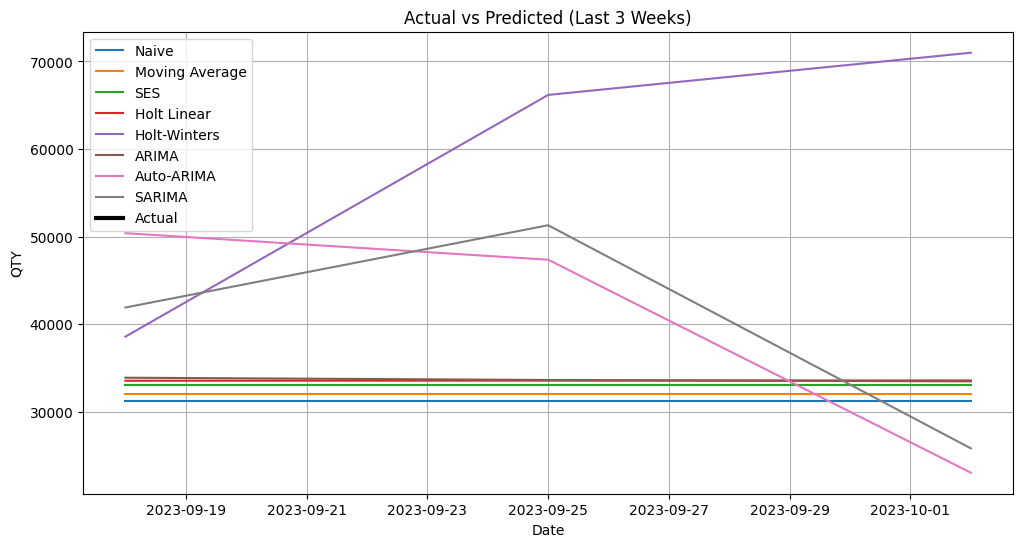

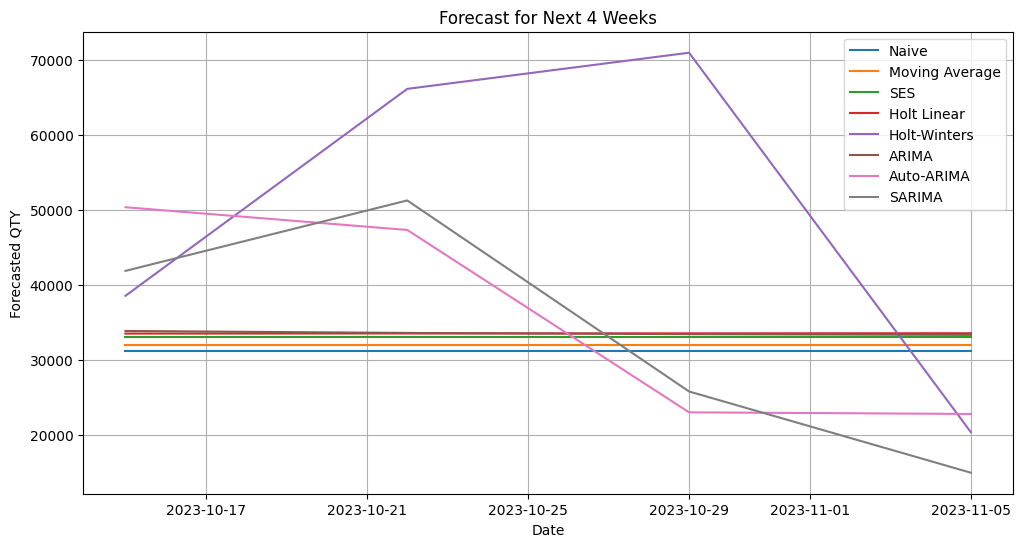

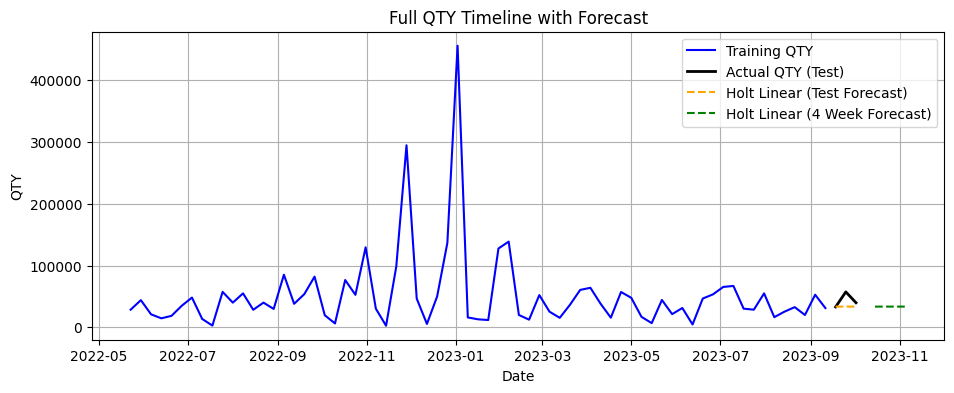


4-Week Forecast by Best Model (Holt Linear):
2023-09-18    33526
2023-09-25    33541
2023-10-02    33556
2023-10-09    33570
Freq: W-MON, dtype: int32


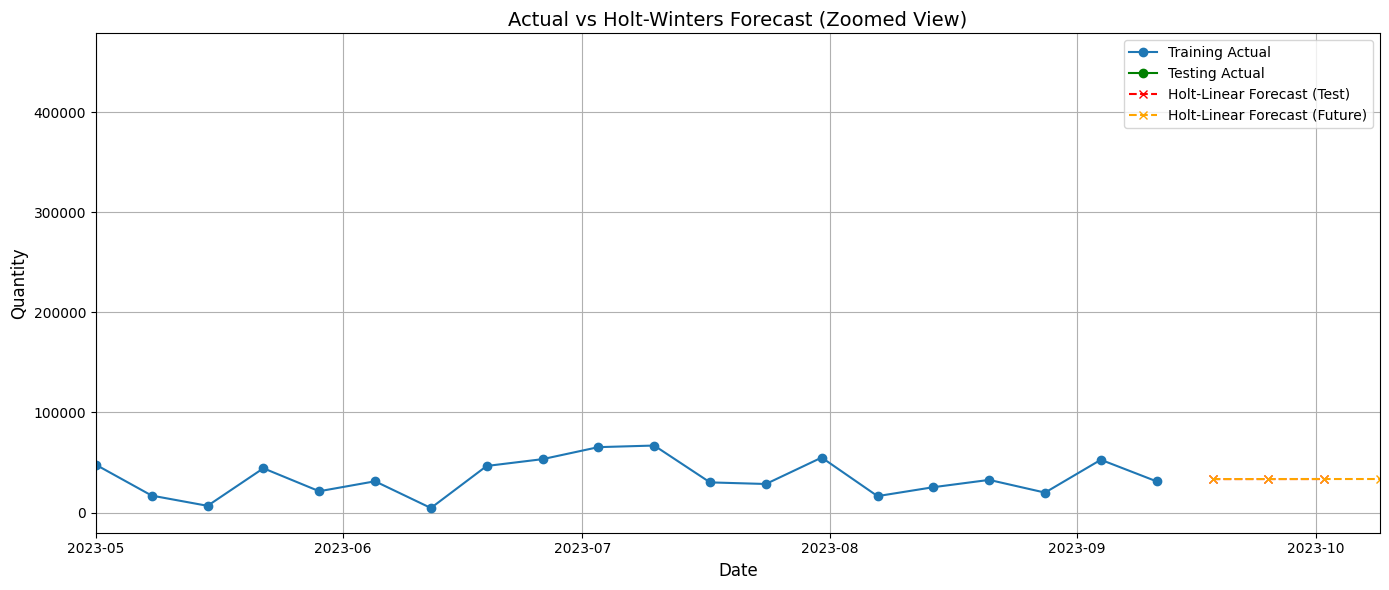

In [600]:
# Plot actual vs predicted
# plt.figure(figsize=(12, 6))

# # Actual (original scale)
# actual_test = np.exp(y_test)
# plt.plot(y_test.index, actual_test, label='Actual', color='black', linewidth=2)

# # Forecasts
# for model, forecast in test_forecasts.items():
#     if forecast is not None and len(forecast) == len(y_test):
#         plt.plot(y_test.index, forecast, label=model)

# plt.title("Actual vs Predicted (Last 3 Weeks)")
# plt.xlabel("Date")
# plt.ylabel("QTY")
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(12, 6))

# Forecasts (plot these first)
for model, forecast in test_forecasts.items():
    if forecast is not None and len(forecast) == len(y_test):
        plt.plot(y_test.index, forecast, label=model)

# Actual (plot last, with thicker line and on top)
actual_test = np.exp(y_test)
plt.plot(y_test.index, actual_test, label='Actual', color='black', linewidth=3, zorder=10)

plt.title("Actual vs Predicted (Last 3 Weeks)")
plt.xlabel("Date")
plt.ylabel("QTY")
plt.legend()
plt.grid(True)
plt.show()




# 2️⃣ PLOT: Forecast for Next 4 Weeks (Original Scale)
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
plt.figure(figsize=(12, 6))
for model, forecast in forecast_4weeks.items():
    plt.plot(future_dates, forecast, label=model)
plt.title("Forecast for Next 4 Weeks")
plt.xlabel("Date")
plt.ylabel("Forecasted QTY")
plt.legend()
plt.grid(True)
plt.show()

# 3️⃣ PLOT: Complete Timeline (Train + Test + Forecast)
plt.figure(figsize=(11, 4))
plt.plot(y_train.index, y_train, label='Training QTY', color='blue')  # Use y_train instead of actual_train
plt.plot(y_test.index, y_test, label='Actual QTY (Test)', color='black', linewidth=2)  # Use y_test instead of actual_test
if best_method in test_forecasts:
    plt.plot(y_test.index, test_forecasts[best_method], '--', label=f'{best_method} (Test Forecast)', color='orange')
if best_method in forecast_4weeks:
    plt.plot(future_dates, forecast_4weeks[best_method], '--', label=f'{best_method} (4 Week Forecast)', color='green')
plt.title("Full QTY Timeline with Forecast")
plt.xlabel("Date")
plt.ylabel("QTY")
plt.legend()
plt.grid(True)
plt.show()

# Print only best forecast
if best_method and best_method in forecast_4weeks:
    print(f"\n4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\nNo valid forecast available from models with MAPE < 10%")
    
    
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot training actual
plt.plot(y_train.index, np.expm1(y_train_log), label='Training Actual', marker='o')

# Plot testing actual
plt.plot(y_test.index, np.expm1(y_test), label='Testing Actual', marker='o', color='green')

# Plot Holt-Winters forecast on test set
plt.plot(y_test.index, test_forecasts['Holt Linear'], label='Holt-Linear Forecast (Test)', linestyle='--', marker='x', color='red')

# Plot Holt-Winters forecast on future
plt.plot(forecast_4weeks['Holt Linear'].index, forecast_4weeks['Holt Linear'].values, label='Holt-Linear Forecast (Future)', linestyle='--', marker='x', color='orange')

# Labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Actual vs Holt-Winters Forecast (Zoomed View)', fontsize=14)
plt.legend()
plt.grid(True)

# Zoom into the last few months
plt.xlim(y_train.index[-20], forecast_4weeks['Holt Linear'].index[-1])

plt.tight_layout()
plt.show()


 

 


 # 📌 Full Demand Forecasting Pipeline for SKU1

# Step-by-step process:
➡️Data Preprocessing 
➡️Smoothing 
➡️Decomposition 
➡️ Stationarity 
➡️ Forecasting
➡️ Model Evaluation 
➡️ Final Forecast
